# Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

# 1. Camera calibration for image undistortion.

For this step, I'll use 20 images of a chessboard, taken from different angles and distances.

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# function for plotting images in grid
def draw_images(images, rows, columns, draw_corners = False):
    fig, axarr = plt.subplots(rows, columns, figsize=(14,7))
    # Show images
    image_index = 0
    corner_index = 0
    for i in range(rows):
        for j in range(columns):
            #img = mpimg.imread(images[image_index])
            img = np.copy(images[image_index])
            if ((draw_corners) and (image_index in indices)):
                corners = imgpoints[corner_index]
                corner_index += 1
                img = cv2.drawChessboardCorners(img, (9,6), corners, True)
            axarr[i, j].axis('off')
            axarr[i, j].imshow(img)
            image_index += 1

 Images for camera calibration: 


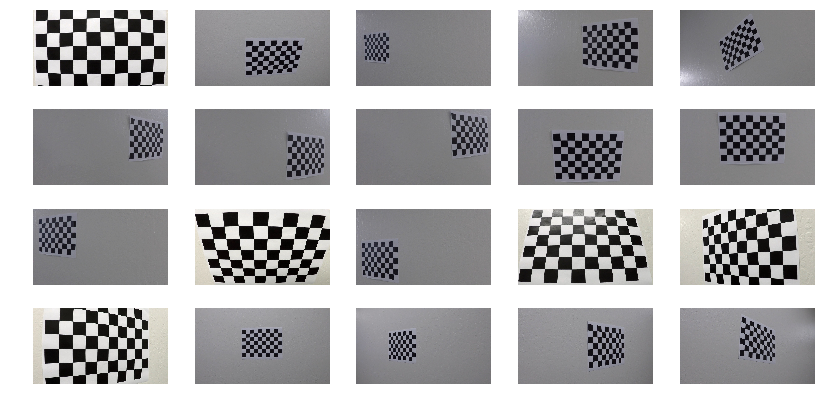

In [3]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)

# chessboard dimensions
chessboard_x = 9
chessboard_y = 6
# grid dimensions 
grid_rows = 4
grid_columns = 5

objp = np.zeros((chessboard_y*chessboard_x,3), np.float32)
objp[:,:2] = np.mgrid[0:chessboard_x,0:chessboard_y].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
image_paths = glob.glob('camera_cal/calibration*.jpg')
image_array = []
for image_path in image_paths:
    image_array.append(mpimg.imread(image_path))
print(' Images for camera calibration: ')
draw_images(image_array, grid_rows, grid_columns)

Now I have to find corners on every image and use them for calibration.
`opencv`'s `findChessboardCorners` is good for detection corners. And to draw corners I'm using `drawChessboardCorners` in the helper function

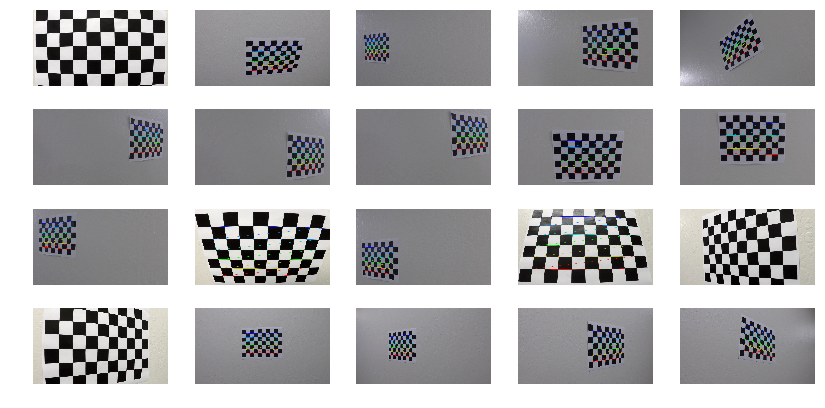

In [4]:
indices = set()
i = 0
for image in image_array:
    gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (chessboard_x, chessboard_y),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        indices.add(i)
    i += 1
draw_images(image_array, grid_rows, grid_columns, True)

Corners successfully detected on 17 images out of 20. Other images seem to doesn't contain apparent 9x6 corners.

Now it's time to calculate the distortion coefficients using these corners. To do this, I apply `opencv`'s `calibrateCamera` function.

In [5]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, image_array[0].shape[1::-1], None, None)

To undistort the image using distortion coefficient, I'll use `opencv`'s `undistort` function

In [6]:
def undistort(img):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

Now one can use this function to undistort any image taken by this camera. Below are undistortion examples for chessboard and road images:

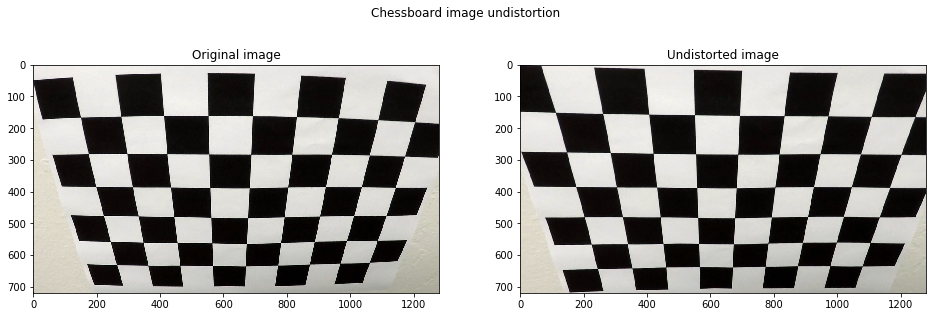

In [7]:
pic = image_array[11]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 5))
plt.suptitle('Chessboard image undistortion')
ax1.set_title('Original image')
ax1.imshow(pic)
ax2.set_title('Undistorted image')
ax2.imshow(undistort(pic))

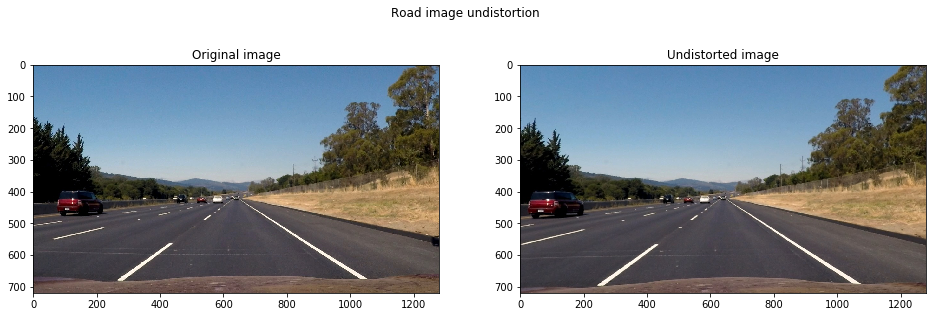

In [8]:
pic = mpimg.imread('test_images/straight_lines2.jpg')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 5))
plt.suptitle('Road image undistortion')
ax1.set_title('Original image')
ax1.imshow(pic)
ax2.set_title('Undistorted image')
ax2.imshow(undistort(pic))

# 2. Gradient and color thresholds.

## 2.1 Gradient

Next step is about finding the edges in an image which are most likely being lane lines.

But first I want to collect some images for tests. Namely I need images containing:
- straight lines
- curved lines
- dotted, sparsed lines

In [9]:
def show_images(name, imgarr, namearr, cmap = None):
    fig, axarr = plt.subplots(1, len(imgarr), figsize = (18, 4))
    plt.suptitle(name)
    for i in range(len(imgarr)):
        axarr[i].set_title(namearr[i])
        axarr[i].axis('off')
        axarr[i].imshow(imgarr[i], cmap = cmap)

For sparsed and straight lines I'll use these images:

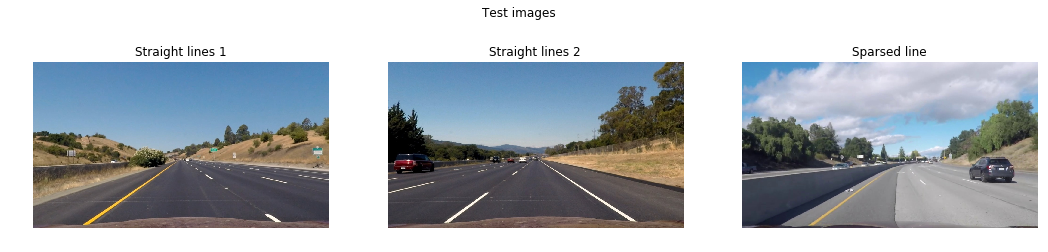

In [10]:
straight1 = undistort(mpimg.imread('test_images/straight_lines1.jpg'))
straight2 = undistort(mpimg.imread('test_images/straight_lines2.jpg'))
sparsed = undistort(mpimg.imread('test_images/sparsed1.jpg'))
imgarr_str = [straight1, straight2, sparsed]
names_str = ['Straight lines 1', 'Straight lines 2', 'Sparsed line']
show_images('Test images', imgarr_str, names_str)

And for curved lines I'll use these images:

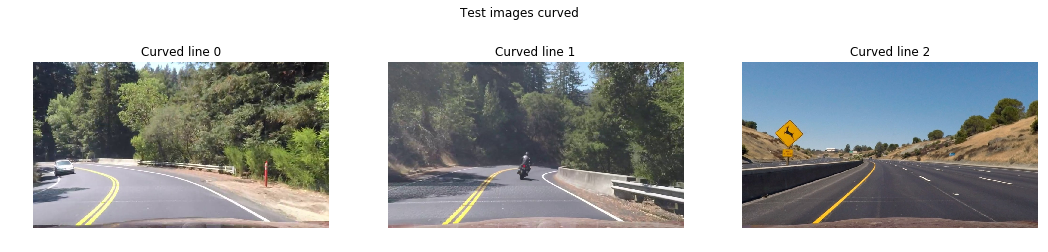

In [11]:
curved_paths = glob.glob('test_images/curved*.jpg')
imgarr_curved = []
names_curved = []
for i, image_path in enumerate(curved_paths):
    imgarr_curved.append(undistort(mpimg.imread(image_path)))
    names_curved.append('Curved line '+str(i))
show_images('Test images curved', imgarr_curved, names_curved)

First I'll use the `opencv`'s `Sobel` function for finding edges in a picture. 

Here I define functions for gradient calculation. 

In [12]:
# Horizontal or vertical gradient
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh = (0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    # Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a mask of 1's where the scaled gradient
    # is > thresh_min and < thresh_max
    sbinary = np.zeros_like(scaled_sobel)
    sbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return sbinary

# Magnitude of horizontal and vertical gradient
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    # Calculate the magnitude
    gr_mag = np.sqrt(sobelx**2 + sobely**2)
    # Scale to 8-bit (0 - 255) and convert to type = np.uint8
    gr_mag_scaled = np.uint8(255*gr_mag/np.max(gr_mag))
    # Create a mask of 1's where the scaled gradient
    # is > thresh_min and < thresh_max
    sbinary = np.zeros_like(gr_mag_scaled)
    sbinary[(gr_mag_scaled >= mag_thresh[0]) & (gr_mag_scaled <= mag_thresh[1])] = 1
    return sbinary

# Direction of horizontal and vertical gradient
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    # Take the absolute value of the x and y gradients
    abs_x = np.absolute(sobelx)
    abs_y = np.absolute(sobely)
    # calculate the direction of the gradient 
    arct = np.arctan2(abs_y, abs_x)
    # Create a mask of 1's where the scaled gradient
    # is > thresh_min and < thresh_max
    mask = np.zeros_like(arct)
    mask[(arct >= thresh[0]) & (arct<=thresh[1])] = 1
    return mask

Applying them on the images from first set gives the following result:

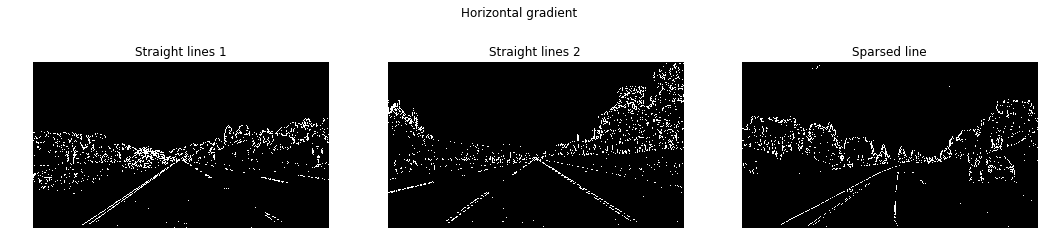

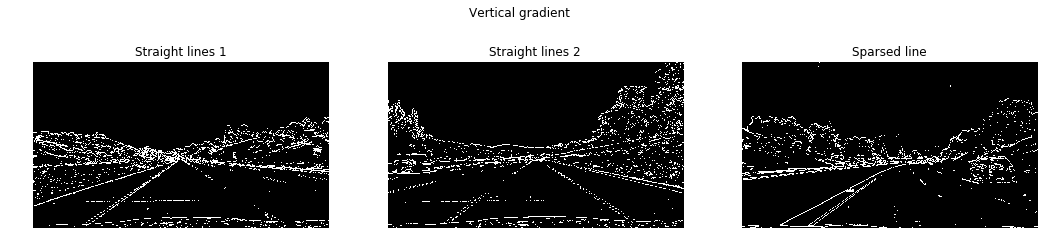

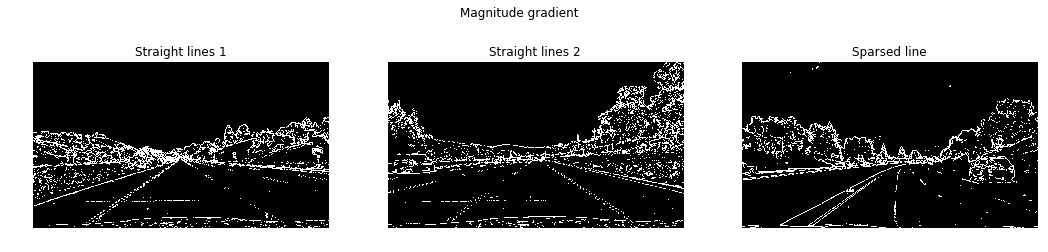

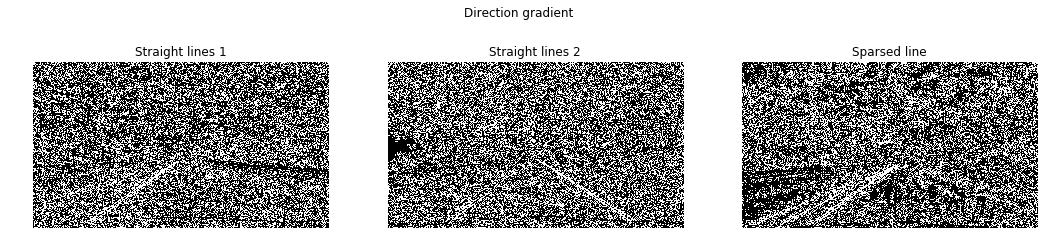

In [13]:
gradx_arr = []
ksize = 3
for image in imgarr_str:
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    gradx_arr.append(gradx)
show_images('Horizontal gradient', gradx_arr, names_str, cmap = 'gray')

grady_arr = []

for image in imgarr_str:
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(20, 100))
    grady_arr.append(grady)
show_images('Vertical gradient', grady_arr, names_str, cmap = 'gray')

gradmag_arr = []

for image in imgarr_str:
    gradmag = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(20, 100))
    gradmag_arr.append(gradmag)
show_images('Magnitude gradient', gradmag_arr, names_str, cmap = 'gray')

graddir_arr = []

for image in imgarr_str:
    graddir = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7, 1.3))
    graddir_arr.append(graddir)
show_images('Direction gradient', graddir_arr, names_str, cmap = 'gray')

It looks like a good idea to combine those approaches for better results. Here are some combining options:

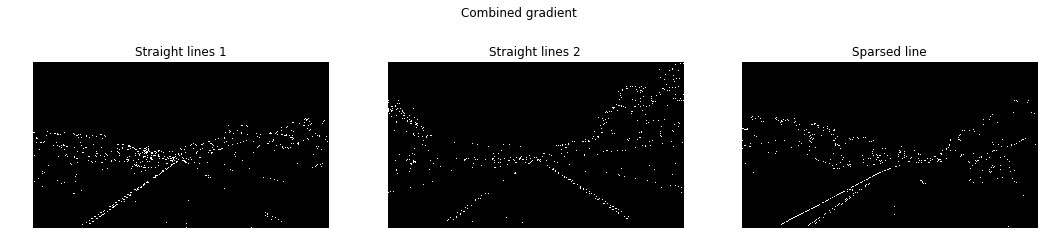

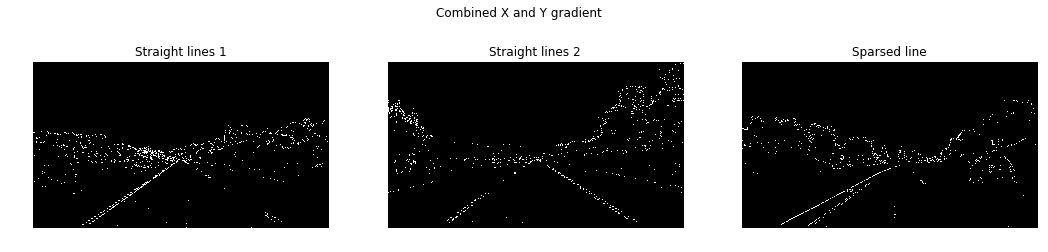

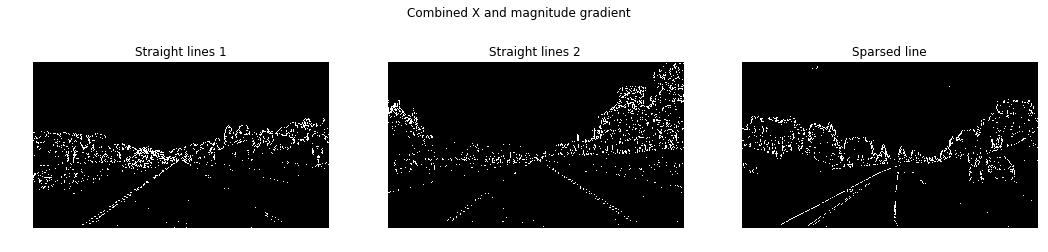

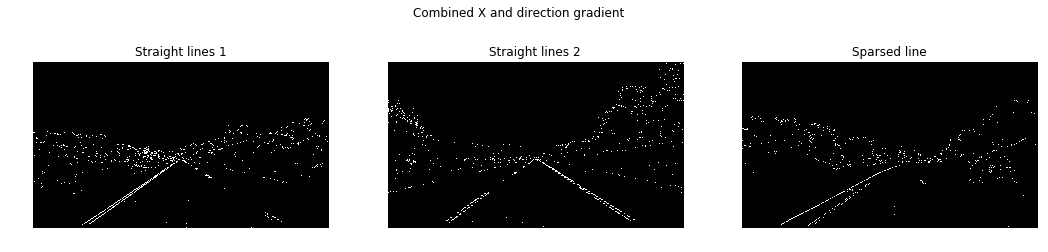

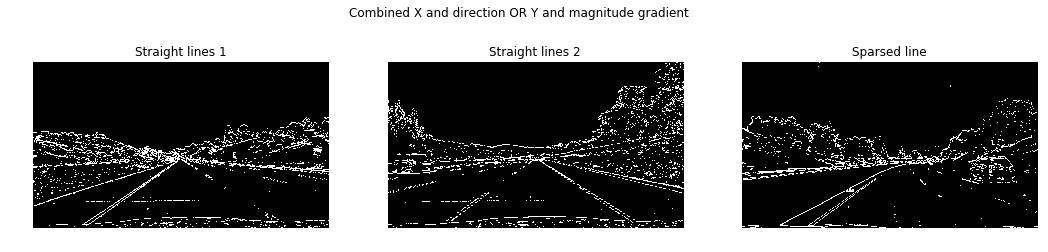

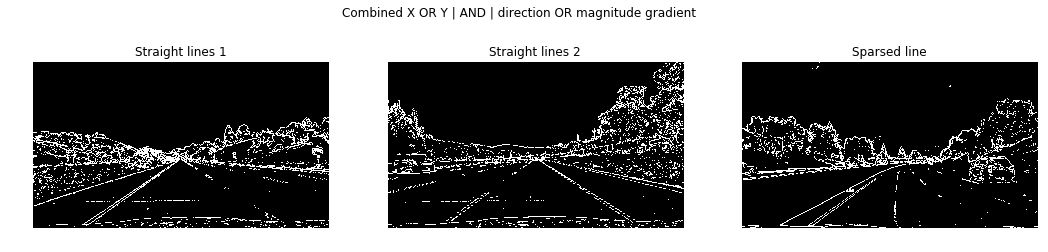

In [14]:
combined_all_arr = []
combined_xy_arr = []
combined_xmag_arr = []
combined_xdir_arr = []
combined_xdir_ymag_arr = []
combined_xy_dirmag_arr = []

for i in range(3):
    gradx = gradx_arr[i]
    grady = grady_arr[i]
    dir_binary = graddir_arr[i]
    mag_binary = gradmag_arr[i]
    
    combined_all = np.zeros_like(dir_binary)
    combined_all[((gradx == 1) & (dir_binary == 1) & (grady == 1) & (mag_binary == 1))] = 1
    combined_all_arr.append(combined_all)
    
    combined_xy = np.zeros_like(dir_binary)
    combined_xy[((gradx == 1) & (grady == 1))] = 1
    combined_xy_arr.append(combined_xy)
    
    combined_xmag = np.zeros_like(dir_binary)
    combined_xmag[((gradx == 1) & (mag_binary == 1))] = 1
    combined_xmag_arr.append(combined_xmag)
    
    combined_xdir = np.zeros_like(dir_binary)
    combined_xdir[((gradx == 1) & (dir_binary == 1))] = 1
    combined_xdir_arr.append(combined_xdir)
    
    combined_xdir_ymag = np.zeros_like(dir_binary)
    combined_xdir_ymag[((gradx == 1) & (dir_binary == 1)) | ((grady == 1) & (mag_binary == 1))] = 1
    combined_xdir_ymag_arr.append(combined_xdir_ymag)
    
    combined_xy_dirmag = np.zeros_like(dir_binary)
    combined_xy_dirmag[(((gradx == 1) | (grady == 1)) & ((dir_binary == 1) | (mag_binary == 1)))] = 1
    combined_xy_dirmag_arr.append(combined_xy_dirmag)
    
    
    #combined[((gradx == 1) & (dir_binary == 1)) | ((grady == 1) & (mag_binary == 1)) ] = 1
show_images('Combined gradient', combined_all_arr, names_str, cmap = 'gray')
show_images('Combined X and Y gradient', combined_xy_arr, names_str, cmap = 'gray')
show_images('Combined X and magnitude gradient', combined_xmag_arr, names_str, cmap = 'gray')
show_images('Combined X and direction gradient', combined_xdir_arr, names_str, cmap = 'gray')
show_images('Combined X and direction OR Y and magnitude gradient', combined_xdir_ymag_arr, names_str, cmap = 'gray')
show_images('Combined X OR Y | AND | direction OR magnitude gradient', combined_xy_dirmag_arr, names_str, cmap = 'gray')

Of all these options penultimate seems like doing the best job.

Now I'll apply same techniques on images with curved lines.

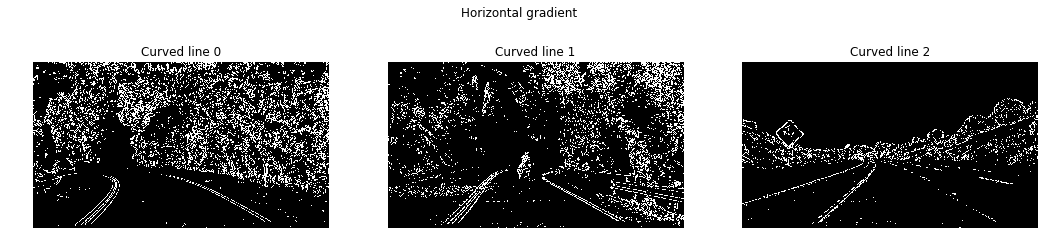

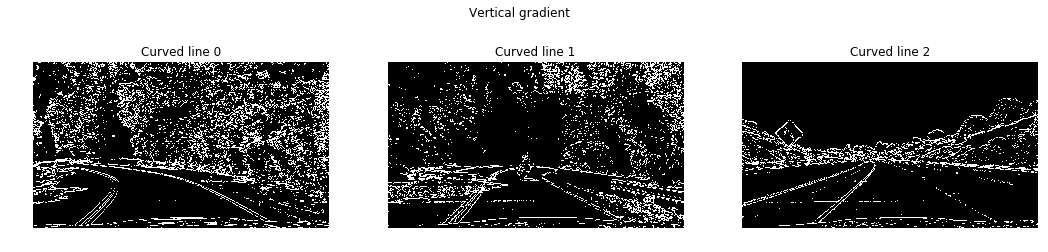

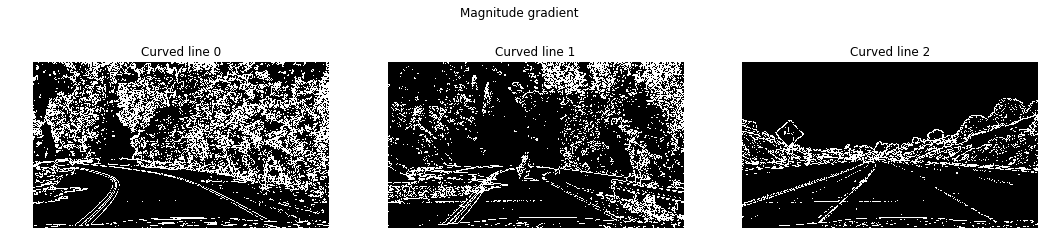

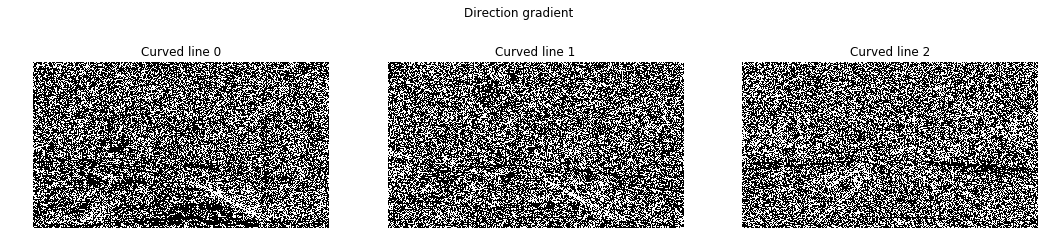

In [15]:
gradx_arr_curved = []
ksize = 3
for image in imgarr_curved:
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    gradx_arr_curved.append(gradx)
show_images('Horizontal gradient', gradx_arr_curved, names_curved, cmap = 'gray')

grady_arr_curved = []
#ksize = 21
for image in imgarr_curved:
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(20, 100))
    grady_arr_curved.append(grady)
show_images('Vertical gradient', grady_arr_curved, names_curved, cmap = 'gray')

gradmag_arr_curved = []
#ksize = 21
for image in imgarr_curved:
    gradmag = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(20, 100))
    gradmag_arr_curved.append(gradmag)
show_images('Magnitude gradient', gradmag_arr_curved, names_curved, cmap = 'gray')

graddir_arr_curved = []
#ksize = 21
for image in imgarr_curved:
    graddir = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7, 1.3))
    graddir_arr_curved.append(graddir)
show_images('Direction gradient', graddir_arr_curved, names_curved, cmap = 'gray')

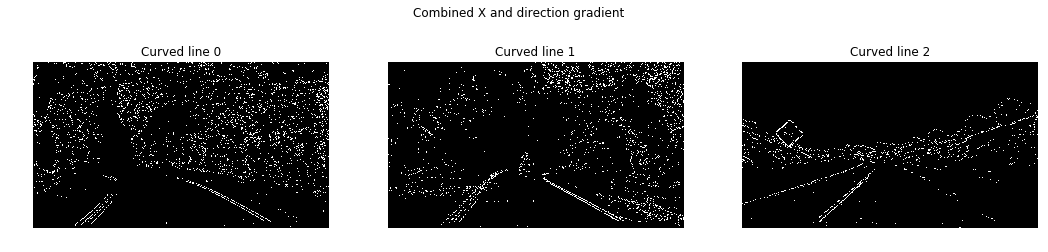

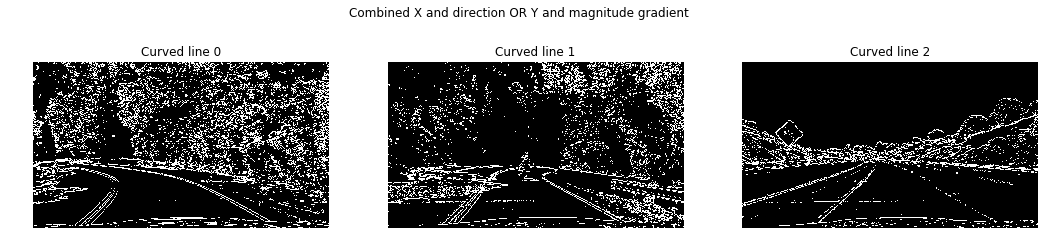

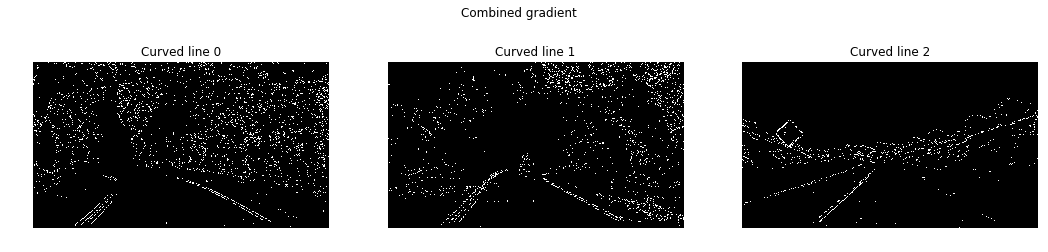

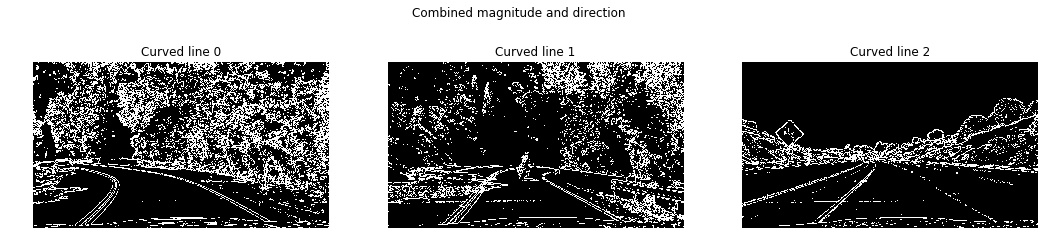

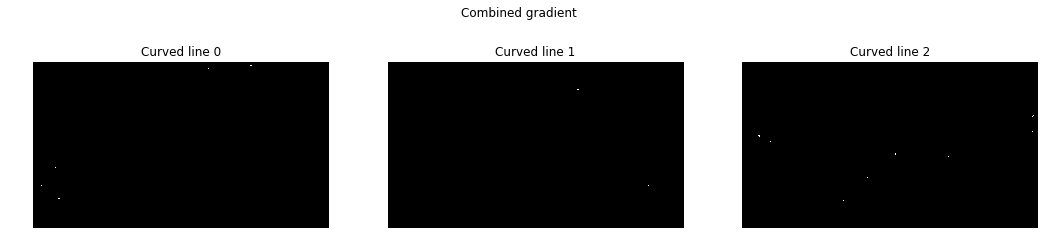

In [16]:
combined_xdir_arr_curved = []
combined_xdir_ymag_arr_curved = []
combined_all_arr_curved = []
combined_mag_dir_arr_curved = []
combined_tr_arr =[]

for i in range(3):
    gradx = gradx_arr_curved[i]
    dir_binary = graddir_arr_curved[i]
    grady = grady_arr_curved[i]
    mag_binary = gradmag_arr_curved[i]
    
    combined_xdir = np.zeros_like(dir_binary)
    combined_xdir[((gradx == 1) & (dir_binary == 1))] = 1
    combined_xdir_arr_curved.append(combined_xdir)
    
    combined_xdir_ymag_curved = np.zeros_like(dir_binary)
    combined_xdir_ymag_curved[((gradx == 1) & (dir_binary == 1)) | ((grady == 1) & (mag_binary == 1))] = 1
    
    combined_xdir_ymag_arr_curved.append(combined_xdir_ymag_curved)
    
    combined_all_curved = np.zeros_like(dir_binary)
    combined_all_curved[((gradx == 1) & (dir_binary == 1) & (grady == 1) & (mag_binary == 1))] = 1
    
    combined_all_arr_curved.append(combined_all_curved)
    
    combined_mag_dir_curved = np.zeros_like(dir_binary)
    combined_mag_dir_curved[(((gradx == 1) | (grady == 1)) & ((dir_binary == 1) | (mag_binary == 1)))] = 1
    combined_mag_dir_arr_curved.append(combined_mag_dir_curved)
    
    combined_tr = np.zeros_like(dir_binary)
    combined_tr[(((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1)))] = 1
    combined_tr_arr.append(combined_tr)
    #kernel = np.ones((5,5),np.uint8)
    #combined_tr = cv2.morphologyEx(combined_tr, cv2.MORPH_OPEN, kernel)
    #combined_tr_arr.append(combined_tr)
    
    
    
show_images('Combined X and direction gradient', combined_xdir_arr_curved, names_curved, cmap = 'gray')
show_images('Combined X and direction OR Y and magnitude gradient', combined_xdir_ymag_arr_curved, names_curved, cmap = 'gray')
show_images('Combined gradient', combined_all_arr_curved, names_curved, cmap = 'gray')
show_images('Combined magnitude and direction', combined_mag_dir_arr_curved, names_curved, cmap = 'gray')
show_images('Combined gradient', combined_tr_arr, names_curved, cmap = 'gray')

Almost every variant has his procs and cons but for me the winner is the `Combined X and direction OR Y and magnitude gradient`

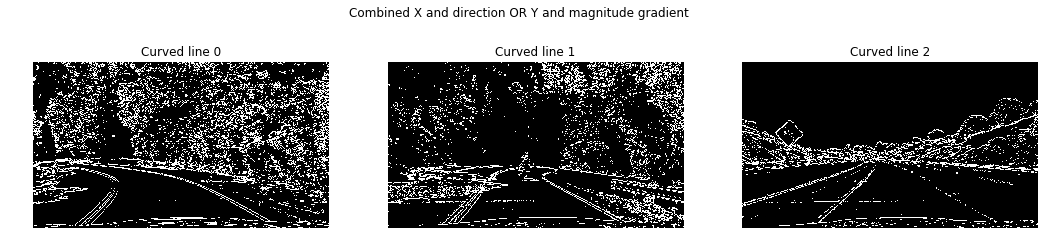

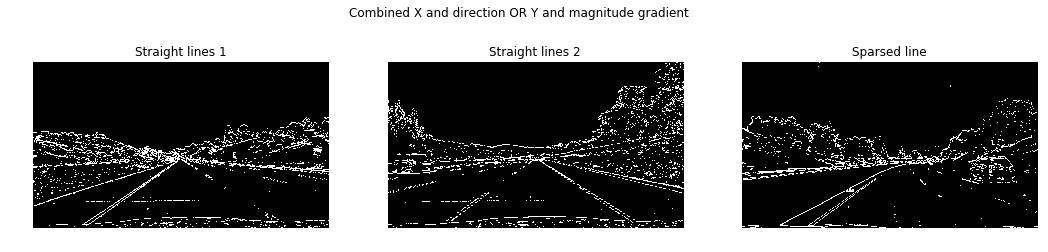

In [17]:
show_images('Combined X and direction OR Y and magnitude gradient', combined_xdir_ymag_arr_curved, names_curved, cmap = 'gray')
show_images('Combined X and direction OR Y and magnitude gradient', combined_xdir_ymag_arr, names_str, cmap = 'gray')

## 2.2. Color threshold

In [18]:
def hls_select(img, thresh=(0, 255)):
    hls_img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_img = hls_img[:,:,2]
    binary_output = np.zeros_like(s_img)
    binary_output[(s_img > thresh[0]) & (s_img <=thresh[1])] = 1
    return binary_output

In [46]:
def color_threshold_hls(image, s_thresh=(100,255)):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    S = hls[:,:,2]
    s_binary = np.zeros_like(S)
    s_binary[(S >= s_thresh[0]) & (S <= s_thresh[1])] = 1
    return s_binary

def color_threshold_luv(image, l_thresh=(100,255)):
    l = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)[:,:,0]
    s_binary = np.zeros_like(l)
    s_binary[(l >= l_thresh[0]) & (l <= l_thresh[1])] = 1
    return s_binary

def color_treshold_lab(image, b_thresh, l_thresh):
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2Lab)
    b_channel = lab[:,:,2]
    l_channel = lab[:,:,0]
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh[0]) & (l_channel <=  l_thresh[1])] = 1
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= b_thresh[0]) & (b_channel <=  b_thresh[1])] = 1
    combined_binary = np.zeros_like(b_channel)
    combined_binary[(l_binary == 1) | (b_binary == 1)] = 1
    return combined_binary

def color_combined(image):
    color_binary_luv = color_threshold_luv(image, l_thresh=(210,255))
    color_binary_lab = color_treshold_lab(image, b_thresh=(155,255), l_thresh=(230,255))
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(dir_binary)
    combined_binary[(color_binary_luv == 1) | (color_binary_lab == 1)] = 1
    return combined_binary

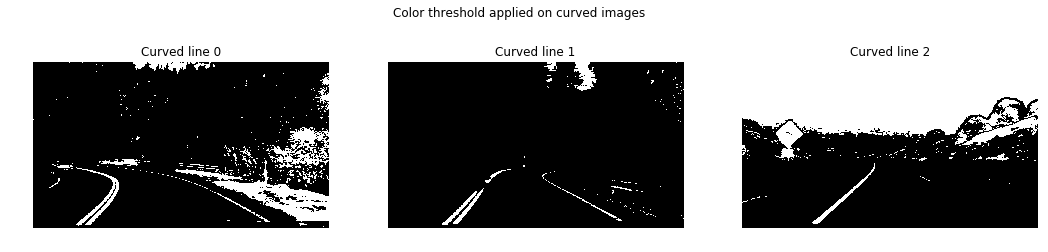

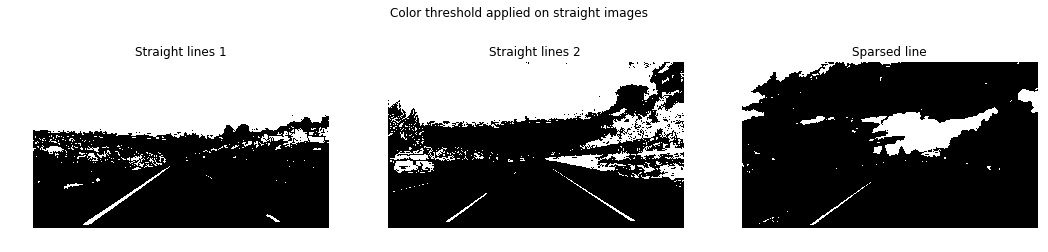

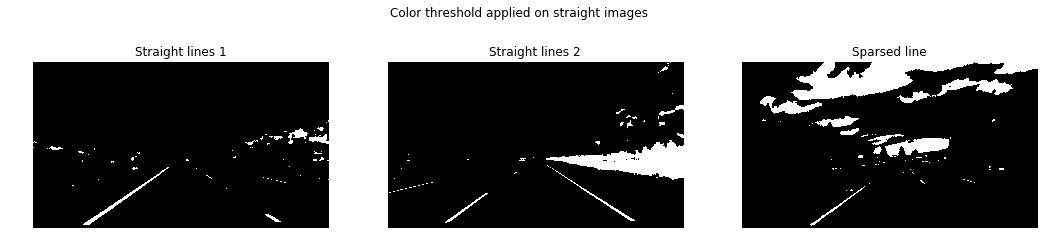

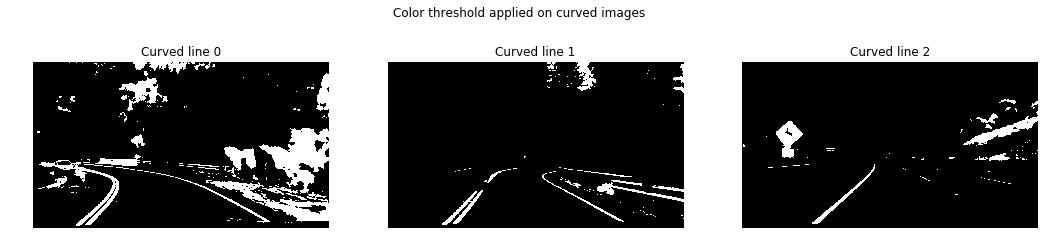

In [49]:
color_curved_arr = []
color_str_arr = []
color_str_arr_n = []
color_curved_arr_n = []
thresh = (90, 255)

for image in imgarr_curved:
    color_curved_arr.append(hls_select(image, thresh = thresh))
show_images('Color threshold applied on curved images', color_curved_arr, names_curved, cmap = 'gray')

for image in imgarr_str:
    color_str_arr.append(hls_select(image, thresh = thresh))
show_images('Color threshold applied on straight images', color_str_arr, names_str, cmap = 'gray')

for image in imgarr_str:
    color_str_arr_n.append(color_combined(image))
show_images('Color threshold applied on straight images', color_str_arr_n, names_str, cmap = 'gray')

for image in imgarr_curved:
    color_curved_arr_n.append(color_combined(image))
show_images('Color threshold applied on curved images', color_curved_arr_n, names_curved, cmap = 'gray')

## 2.3. Combining gradient and color thresholds:

Finally, I'll combine color and gradient thresholds.

In [75]:
# this function will be used for threshold combination.
def combine_tresholds(image, xy_thresh=(20,100), m_thresh=(20,100), dir_thresh=(0.7,1.3), color_thresh=(80, 255), kernel = 3):
    img = np.copy(image)
    # get all 4 types of gradient
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=kernel, thresh = xy_thresh)
    grady = abs_sobel_thresh(img, orient='y', sobel_kernel=kernel, thresh = xy_thresh)   
    mag_binary = mag_thresh(img, sobel_kernel=kernel, mag_thresh=m_thresh)
    dir_binary = dir_threshold(img, sobel_kernel=kernel, thresh=dir_thresh)
    # combine gradient the best way
    gradient_binary = np.zeros_like(dir_binary)
    gradient_binary[((gradx == 1) & (dir_binary == 1)) | ((grady == 1) & (mag_binary == 1))] = 1
    kernel = np.ones((5,5),np.uint8)
    gradient_binary = cv2.morphologyEx(gradient_binary, cv2.MORPH_OPEN, kernel)
    #combined_tr_arr.append(combined_tr)
    # apply color threshold on source image
    color_binary = color_combined(img)
    # combine color and gradient thresholds
    combined_binary = np.zeros_like(image[:,:,0])
    combined_binary[(gradient_binary == 1) | (color_binary == 1)] = 1
    return combined_binary

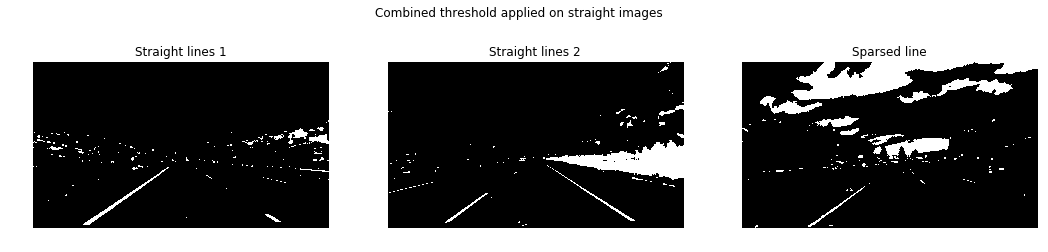

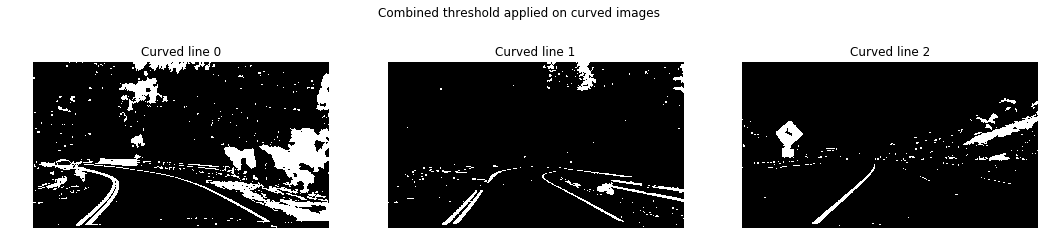

In [76]:
combined_str_arr = []
combined_curved_arr = []

for image in imgarr_str:
    combined_str_arr.append(combine_tresholds(image))
show_images('Combined threshold applied on straight images', combined_str_arr, names_str, cmap = 'gray')

for image in imgarr_curved:
    combined_curved_arr.append(combine_tresholds(image))
show_images('Combined threshold applied on curved images', combined_curved_arr, names_curved, cmap = 'gray')

Now the lines look way better.

# 3. Perspective transform.

For performing the perspective transformation I'll need an image with straight lines. These lines are supposed to be strict and parallel to each other. So slicing them with another two parallel lines which are perpendicular to them will result a rectangle.

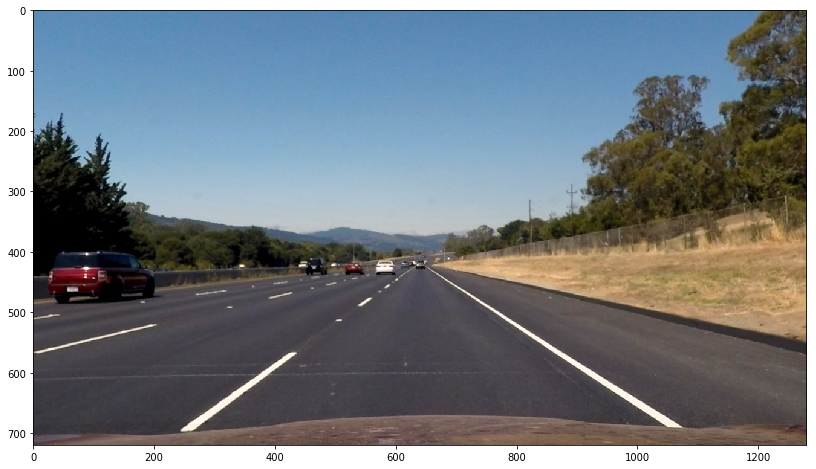

In [68]:
%matplotlib inline
plt.figure(figsize = (16,8))
plt.imshow(imgarr_str[1], cmap = 'gray')

In [112]:
def perspective_transform(image):
    # Grab the image shape
    img_size = (image.shape[1], image.shape[0])
    (h, w) = (image.shape[0], image.shape[1])
    # Define source points and destination 
    src = np.float32([[  564. ,  450.],[716. ,  450.],[ -100. ,  720.],[ 1380. ,  720.]])
    dst = np.float32([[  100. , 0.],[1280. ,   0.],[100.  , 720.],[ 1280. ,  720.]])
    
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(image, M, img_size)

    # Return the resulting image and matrix
    return warped, M, Minv

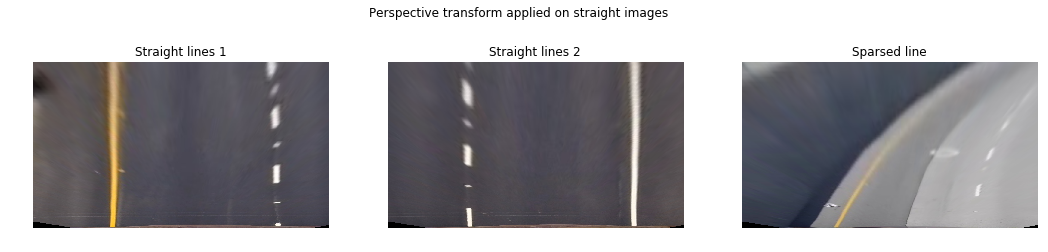

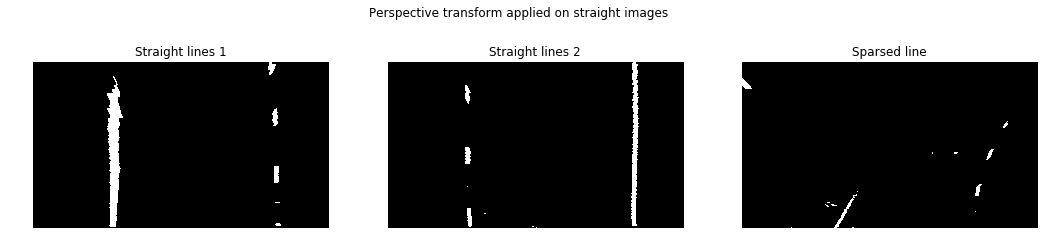

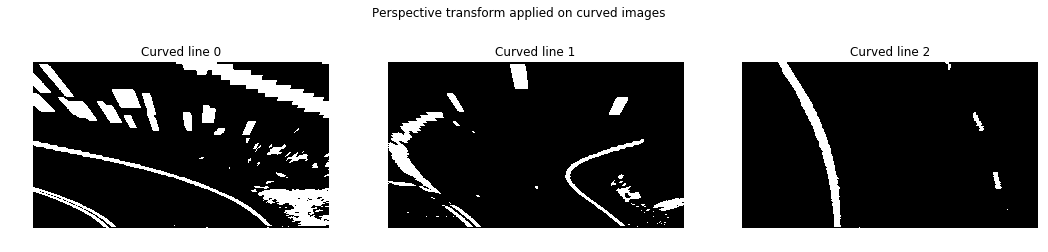

In [350]:
transformed_str = []
for image in imgarr_str:
    warped, M, Minv = perspective_transform(image)
    transformed_str.append(warped)
show_images('Perspective transform applied on straight images', transformed_str, names_str, cmap = 'gray')
transformed_str_thresh = []
for image in combined_str_arr:
    warped, M, Minv = perspective_transform(image)
    transformed_str_thresh.append(warped)
show_images('Perspective transform applied on straight images', transformed_str_thresh, names_str, cmap = 'gray')
transformed_curved_thresh = []
for image in combined_curved_arr:
    warped, M, Minv = perspective_transform(image)
    transformed_curved_thresh.append(warped)
show_images('Perspective transform applied on curved images', transformed_curved_thresh, names_curved, cmap = 'gray')

# 4. Finding lane boundary

First I'll need the starting point of the lines. For this I'll take the very bottom of the image since there is still some large noize in curved images.

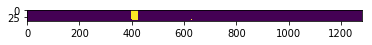

In [352]:
img = transformed_curved_thresh[2]
img_cut = img[680:,:]
plt.imshow(img_cut)

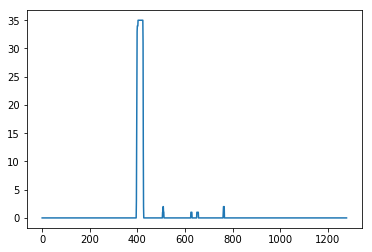

In [353]:
img = transformed_curved_thresh[2]
import numpy as np
histogram = np.sum(img[680:,:], axis=0)
plt.plot(histogram)

There were alot of experiments with code and different images...

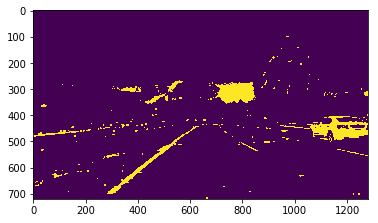

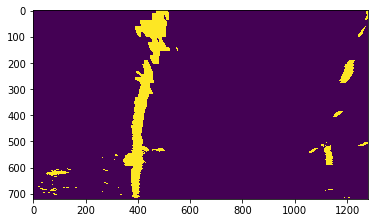

In [469]:
#binary_warped = transformed_curved_thresh[0]
test_image = undistort(mpimg.imread("test_images/test4.jpg"))
test_image = combine_tresholds(test_image)
plt.figure()
plt.imshow(test_image)
binary_warped, M, Minv = perspective_transform(test_image)
plt.figure()
plt.imshow(binary_warped)

In [470]:
# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[680:,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
print('midpoint', midpoint)
leftx_base = np.argmax(histogram[:midpoint])
print(np.max(histogram[midpoint:1100]))
if(np.max(histogram[midpoint:1100]) > 20):
    rightx_base = np.argmax(histogram[midpoint:1100]) + midpoint
else:
    rightx_base = 1050
print('rightx_base', rightx_base)
# Choose the number of sliding windows
nwindows = 100
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 50
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    # Identify the nonzero pixels in x and y within the window
    # Append these indices to the lists
    # If you found > minpix pixels, recenter next window on their mean position
    # But only in case the lane is not very curved
    
    if(win_xleft_low > -margin/2):
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        left_lane_inds.append(good_left_inds)
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if(win_xright_low > -margin/2):
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        right_lane_inds.append(good_right_inds)
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

midpoint 640
3
rightx_base 1050


(720, 0)

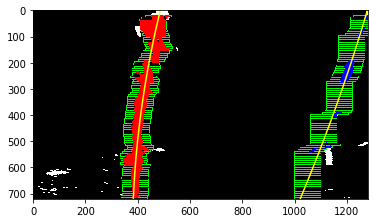

In [471]:
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [472]:
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
left_fit[1]*nonzeroy + left_fit[2] + margin))) 

right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

(720, 0)

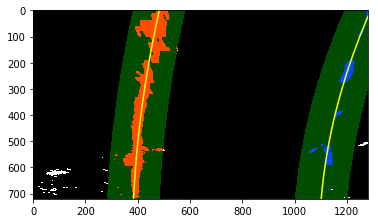

In [473]:
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [474]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*result.shape[0]*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*result.shape[0]*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
radius = (left_curverad + right_curverad)/2

print(left_curverad, 'm', right_curverad, 'm')
print(radius, 'm')

1353.7183902149225 m 669.8953687426131 m
1011.8068794787678 m


All right, this radius looks good. It's time to build actual pipeline

In [483]:
def find_lanes(binary_warped, nwindows = 9):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[680:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    print('midpoint', midpoint)
    leftx_base = np.argmax(histogram[:midpoint])
    print(np.max(histogram[midpoint:1100]))
    if(np.max(histogram[midpoint:1100]) > 20):
        rightx_base = np.argmax(histogram[midpoint:1100]) + midpoint
    else:
        rightx_base = 1050
    print('rightx_base', rightx_base)
    # Choose the number of sliding windows
    nwindows = 100
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 50
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin

        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        # Identify the nonzero pixels in x and y within the window
        # Append these indices to the lists
        # If you found > minpix pixels, recenter next window on their mean position
        # But only in case the lane is not very curved

        if(win_xleft_low > -margin/2):
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
            (0,255,0), 2) 
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            left_lane_inds.append(good_left_inds)
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if(win_xright_low > -margin/2):
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
            (0,255,0), 2) 
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
            right_lane_inds.append(good_right_inds)
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    return out_img, left_fitx, right_fitx, leftx, lefty, rightx, righty, ploty

def draw_lines(image, binary_warped, left_fitx, right_fitx, ploty, Minv ):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    return result

def compute_radius_offset(leftx, lefty, rightx, righty, shape):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]* shape[0]*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]* shape[0]*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    radius = (left_curverad + right_curverad)/2
        
    return radius

midpoint 640
14
rightx_base 1050
midpoint 640
32
rightx_base 1061
midpoint 640
0
rightx_base 1050
midpoint 640
27
rightx_base 1010
midpoint 640
18
rightx_base 1050
midpoint 640
2
rightx_base 1050


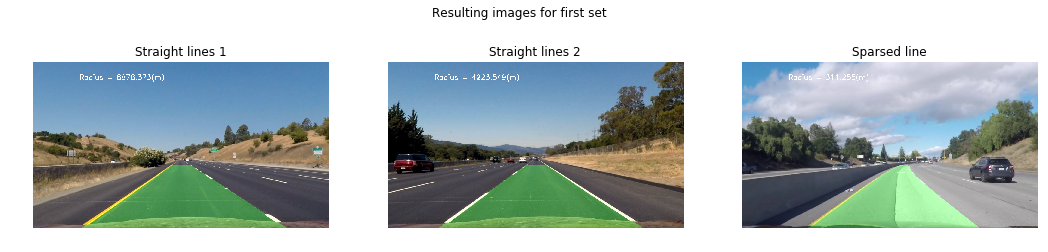

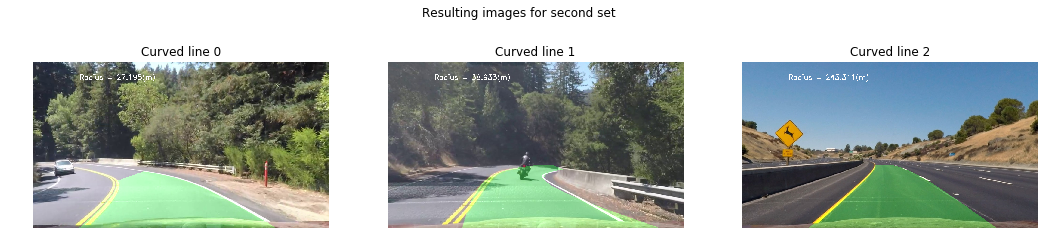

In [503]:
result_str_arr = []
for image in imgarr_str:
    #image = undistort(mpimg.imread("test_images/curved3.jpg"))
    tresholded = combine_tresholds(image)
    binary_warped, M, Minv = perspective_transform(tresholded)
    out_img, left_fitx, right_fitx, leftx, lefty, rightx, righty, ploty  = find_lanes(binary_warped)
    result = draw_lines(image, binary_warped, left_fitx, right_fitx, ploty, Minv )
    radius = compute_radius_offset(leftx, lefty, rightx, righty, image.shape)
    cv2.putText(result, 'Radius = {}(m)'.format(round(radius, 3)), 
                (200,20*4),fontFace = 16, fontScale = 1, color=(255,255,255), thickness = 2) 
    result_str_arr.append(result)
show_images('Resulting images for first set', result_str_arr, names_str)

result_curved_arr = []
for image in imgarr_curved:
    #image = undistort(mpimg.imread("test_images/curved3.jpg"))
    tresholded = combine_tresholds(image)
    binary_warped, M, Minv = perspective_transform(tresholded)
    out_img, left_fitx, right_fitx, leftx, lefty, rightx, righty, ploty  = find_lanes(binary_warped)
    result = draw_lines(image, binary_warped, left_fitx, right_fitx, ploty, Minv )
    radius = compute_radius_offset(leftx, lefty, rightx, righty, image.shape)
    cv2.putText(result, 'Radius = {}(m)'.format(round(radius, 3)), 
                (200,20*4),fontFace = 16, fontScale = 1, color=(255,255,255), thickness = 2) 
    result_curved_arr.append(result)
show_images('Resulting images for second set', result_curved_arr, names_curved)

Looks OK, but need to improve a little.